In [1]:
import torch
import numpy as np
import os
from matplotlib import pyplot as plt

In [8]:
IMG_PATH = 'data/ants/frames_cropped_224'
KEYPOINT_PATH = 'data/ants/crop_keypoints.npy'

In [16]:
keypoints = np.load(KEYPOINT_PATH, allow_pickle=True).item()
len(keypoints.keys())
keypoints[list(keypoints.keys())[0]]

{'keypoints': array([[0.46   , 0.33125, 0.3825 , 0.5525 ],
        [0.4575 , 0.33   , 0.38125, 0.55125],
        [0.4575 , 0.32875, 0.38125, 0.55125],
        ...,
        [0.465  , 0.325  , 0.39375, 0.5575 ],
        [0.465  , 0.325  , 0.39375, 0.5575 ],
        [0.46375, 0.325  , 0.39375, 0.5575 ]], dtype=float32),
 'annotations': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)}

In [17]:
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode

In [111]:
def crop(frame, center, size=112):
        """
        Crop the frame with the given center and size
        frame 7 * W * H
        center (y, x)
        """
        center = np.array(center) * 512
        y1, x1 = center[0] - size // 2, center[1] - size // 2
        y2, x2 = y1 + size, x1 + size
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(frame.shape[1], x2), min(frame.shape[2], y2)
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        print(x1, y1, x2, y2)
        crop_frame = frame[:, x1:x2, y1:y2].float()
        crop_frame = torch.nn.functional.interpolate(
            crop_frame.unsqueeze(0), size=112, mode="bilinear", align_corners=False
        )[0]
        return crop_frame

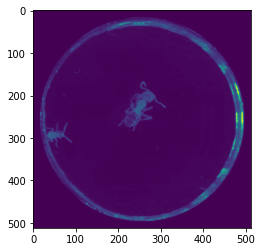

In [134]:
frame_path = 'data/ants/frames_cropped_224/26414d8922b6813b8a40/400_full.jpg'
frame = read_image(frame_path, mode=ImageReadMode.GRAY)
plt.imshow(frame.permute(1, 2, 0))

In [135]:
pos = keypoints['26414d8922b6813b8a40']['keypoints'][400]
y1, x1, y2, x2 = pos
# pos = torch.from_numpy(keypoints['0c2b2569b2434cbd5887']['keypoints'].reshape(-1, 2, 900)).permute(2, 0, 1)[400]
pos1 = [x1, y1]
pos2 = [x2, y2]
print(pos1)
print(pos2)

[0.08375, 0.5725]
[0.4475, 0.49]


torch.Size([1, 512, 512])
237 0 349 98


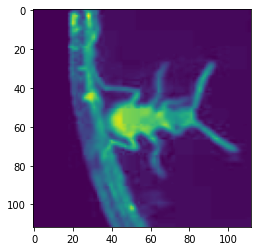

194 173 306 285


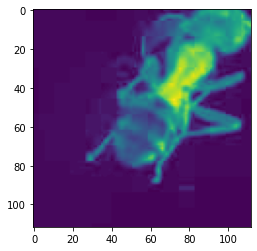

In [136]:
print(frame.shape)
crop_img = crop(frame, pos1, 112)
plt.imshow(crop_img.permute(1, 2, 0))
plt.show()
crop_img = crop(frame, pos2, 112)
plt.imshow(crop_img.permute(1, 2, 0))
plt.show()

In [11]:
import torch
import torch.nn as nn
import numpy as np
import kornia


class FAME(nn.Module):
    def __init__(self, crop_size=112, beta=0.5, device="cpu", eps=1e-8):
        super(FAME, self).__init__()
        self.crop_size = crop_size
        gauss_size = int(0.1 * crop_size) // 2 * 2 + 1
        self.gauss = kornia.filters.GaussianBlur2d(
            (gauss_size, gauss_size),
            (gauss_size / 3, gauss_size / 3))
        self.device = device
        self.eps = eps
        self.beta = beta # control the portion of foreground

    #### min-max normalization
    def norm_batch(self, matrix):
        # matrix : B*H*W
        B, H, W = matrix.shape
        matrix = matrix.flatten(start_dim=1)
        matrix -= matrix.min(dim=-1, keepdim=True)[0]
        matrix /= (matrix.max(dim=-1, keepdim=True)[0] + self.eps)
        return matrix.reshape(B, H, W)

    def batched_bincount(self, x, dim, max_value):
        target = torch.zeros(x.shape[0], max_value, dtype=x.dtype, device=x.device)
        values = torch.ones_like(x)
        target.scatter_add_(dim, x, values)
        return target
    
    def getSeg(self, mask, video_clips):
        # input mask:B, H, W; video_clips:B, C, T, H, W
        # return soft seg mask: B, H, W
        B, C, T, H, W = video_clips.shape
        video_clips_ = video_clips.mean(dim=2) # B, C, H, W
        img_hsv = kornia.color.rgb_to_hsv(video_clips_.reshape(-1, C, H, W))  # B, C, H, W
        sampled_fg_index = torch.topk(mask.reshape(B, -1), k=int(0.5 * H * W), dim=-1)[1]  # shape B * K
        sampled_bg_index = torch.topk(mask.reshape(B, -1), k=int(0.1 * H * W), dim=-1, largest=False)[1]  # shape B * K

        dimH, dimS, dimV = 10, 10, 10
        img_hsv = img_hsv.reshape(B, -1, H, W)  # B * C * H * W
        img_h = img_hsv[:, 0]
        img_s = img_hsv[:, 1]
        img_v = img_hsv[:, 2]
        hx = (img_s * torch.cos(img_h * 2 * np.pi) + 1) / 2
        hy = (img_s * torch.sin(img_h * 2 * np.pi) + 1) / 2
        h = torch.round(hx * (dimH - 1) + 1)
        s = torch.round(hy * (dimS - 1) + 1)
        v = torch.round(img_v * (dimV - 1) + 1)
        color_map = h + (s - 1) * dimH + (v - 1) * dimH * dimS  # B, H, W
        color_map = color_map.reshape(B, -1).long()
        col_fg = color_map.gather(index=sampled_fg_index, dim=-1)  # B * K
        col_bg = color_map.gather(index=sampled_bg_index, dim=-1)  # B * K
        
        dict_fg = self.batched_bincount(col_fg, dim=1, max_value=dimH * dimS * dimV)  # B * (dimH * dimS * dimV)
        dict_bg = self.batched_bincount(col_bg, dim=1, max_value=dimH * dimS * dimV)  # B * (dimH * dimS * dimV)
        dict_fg = dict_fg.float()
        dict_bg = dict_bg.float() + 1
        dict_fg /= (dict_fg.sum(dim=-1, keepdim=True) + self.eps)
        dict_bg /= (dict_bg.sum(dim=-1, keepdim=True) + self.eps)

        pr_fg = dict_fg.gather(dim=1, index=color_map)
        pr_bg = dict_bg.gather(dim=1, index=color_map)
        refine_mask = pr_fg / (pr_bg + pr_fg)

        mask = self.gauss(refine_mask.reshape(-1, 1, H, W))
        mask = self.norm_batch(mask.reshape(-1, H, W))
        num_fg = int(self.beta * H * W)
        sampled_index = torch.topk(mask.reshape(B, -1), k=num_fg, dim=-1)[1]
        mask = torch.zeros_like(mask).reshape(B, -1)
        b_index = torch.LongTensor([[i]*num_fg for i in range(B)])
        mask[b_index.view(-1), sampled_index.view(-1)] = 1
        return mask.reshape(B, H, W)

    def getmask(self, video_clips):
        # input video_clips: B, C, T, H, W
        # return soft seg mask: B, H, W
        B, C, T, H, W = video_clips.shape
        im_diff = (video_clips[:, :, 0:-1] - video_clips[:, :, 1:]).abs().sum(dim=1).mean(dim=1)  # B, H, W
        mask = self.gauss(im_diff.reshape(-1, 1, H, W))
        mask = self.norm_batch(mask.reshape(-1, H, W))  # B, H, W
        mask = self.getSeg(mask, video_clips)
        return mask

    def forward(self, video_clips):
        # return video_clips : B, C, T, H, W
        mask = self.getmask(video_clips)
        B, C, T, H, W = video_clips.shape
        index = torch.randperm(B, device=self.device)
        video_fuse = video_clips[index] * (1 - mask).reshape(-1, 1, 1, H, W) + video_clips * mask.reshape(-1, 1, 1, H, W)
        return video_fuse


f = FAME()
video_clips = torch.randn(2, 3, 16, 224, 224)
mask = f.forward(video_clips)
print(mask.shape)

RuntimeError: index -766 is out of bounds for dimension 1 with size 1000

In [ ]:
def calc_ranking_loss(self, features, n_views=2, prefix='ranking_', weight=1.):
    '''
        corresponding shuffled features should be the same
        while also surpasing the second highest features by margin (hyperparam) = 0
    '''
    # input features is normed features
    assert len(features.size()) == 4, features.size()
    Bn, n_series, N, dim = features.size()
    assert n_series == self.n_series
    assert N == n_views and dim == self.series_dim, features.size()

    labels = torch.cat([torch.arange(n_series) for i in range(n_views)], dim=0)  # (2, n_series) -> (2*n_Series,)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()  # (2s, 2s)
    labels = labels.cuda()

    features = features.permute(0,2,1,3).contiguous().view(Bn, n_views*n_series, dim)

    similarity_matrix = torch.bmm(features, features.transpose(2,1).contiguous()) # (bn, 2s, 2s)

    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(labels.shape[0], dtype=torch.bool).cuda().unsqueeze(0).expand_as(similarity_matrix)
    corr_mask_1 = torch.cat([torch.zeros(n_series, n_series), torch.eye(n_series)], dim=1)
    corr_mask_2 = torch.cat([torch.eye(n_series), torch.zeros(n_series, n_series)], dim=1)
    corr_mask = torch.cat([corr_mask_1, corr_mask_2]).cuda().bool().unsqueeze(0).expand_as(similarity_matrix)
    left_mask = ~(mask | corr_mask)

    highest_similarity = similarity_matrix[corr_mask].view(Bn, 2*n_series, 1)
    second_highest_similarity = similarity_matrix[left_mask].view(Bn, 2*n_series, 2*n_series-2)
    diff =  second_highest_similarity - highest_similarity
    margin_loss = weight * torch.log(1 + torch.exp(diff / 0.05)).mean()

    margin_logits = torch.cat([highest_similarity, second_highest_similarity], dim=2).view(-1, 2*n_series-1)
    margin_labels = torch.zeros(margin_logits.size(0)).long().cuda()

    ret = {
        f"{prefix}margin_logits": margin_logits,
        f"{prefix}margin_labels": margin_labels,
        f"{prefix}margin_contrast_loss": margin_loss
    }

    return ret


In [19]:
import torch
import numpy as np


n_series = 2
B = 16
C = 3
T = 8
H = W = 224

aug_x1 = torch.rand(B, C, n_series, T // n_series, H, W)
sample_indices = torch.tensor(
    np.array([np.random.permutation(n_series) for i in range(B)])
).long()
sample_gather_indices = sample_indices.view(B, 1, n_series, 1, 1, 1).expand_as(aug_x1)
shuffled_aug_x1 = torch.gather(aug_x1, 2, sample_gather_indices).contiguous().view(B, C, T, H, W)  # (B*n, C, T, H, W)
aug_x1 = aug_x1.view(B, C, T, H, W)


tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]])
